## DL Ops Assignment 4
### Question 1
#### Submitted by - Debonil Ghosh [ M21AIE225 ]

In [1]:
import pandas as pd
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt
print('Starting ...')



Starting ...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Available device ==> {device}')



Available device ==> cuda:0


In [4]:


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [5]:
# Train the model
def model_training(model, criterion, optimizer, trainloader, testloader, num_epochs=10, model_name='model'):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs, labels)
            #print(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(labels.cpu().detach(
            ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ', flush=True)
        loss_list.append([train_loss, val_loss, train_acc, val_acc])

    print(
        f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]



In [6]:
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    plt.show()
    plt.savefig(
        f'confusion_mat_{title}_{time.time()}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())



In [7]:
def plot_training_graphs(loss_list, title=''):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title(f"{title} : Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title(f"{title} : Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()
    plt.savefig(
        f'training_loss_{title}_{time.time()}.png', bbox_inches='tight')



In [8]:


def view_samples(testloader, classes):

    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize=(20, 7))
    nrows = 3
    ncols = 10
    b = np.random.randint(0, test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(classes[labels[i+b].cpu().numpy()])
        plot.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu())
    plt.show()
    plt.savefig(f'view_samples_{time.time()}.png', bbox_inches='tight')


def filter_dataset(dataset_full):
    # Selecting even classes 0,2,4,6,8 as roll number is odd (M21AIE225)
    targets = np.array(dataset_full.targets)
    idx = (targets == 0) | (targets == 2) | (
        targets == 4) | (targets == 6) | (targets == 8)
    dataset_full.targets = np.rint(targets[idx]/2).astype(int)
    dataset_full.data = dataset_full.data[idx]
    dataset_full.classes = [dataset_full.classes[c] for c in [0, 2, 4, 6, 8]]
    return dataset_full



In [9]:
from torch.utils.data import Dataset
import pandas as pd
class CustomDataset(Dataset):
    def __init__(self, csv_path, transform=None,train = True):
        self.transform = transform
        df = pd.read_csv(csv_path).dropna().sample(frac=0.8 if train else 0.2)
        self.classes = np.sort(df['character'].unique())
        self.class_to_idx = {k: v for v, k in enumerate(self.classes)}
        self.labels = df['character'].values
        mapper_fn = lambda x: self.class_to_idx[x]
        self.targets = np.vectorize(mapper_fn)(self.labels)
        self.np_imgs = df.drop('character',axis=1).apply(lambda x: np.array(x,dtype=np.float32).reshape((32,32)), axis=1).values
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.np_imgs[idx]
        
        label = self.targets[idx]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long, device=device)

Data Loading ...
torch.Size([64, 1, 64, 64])


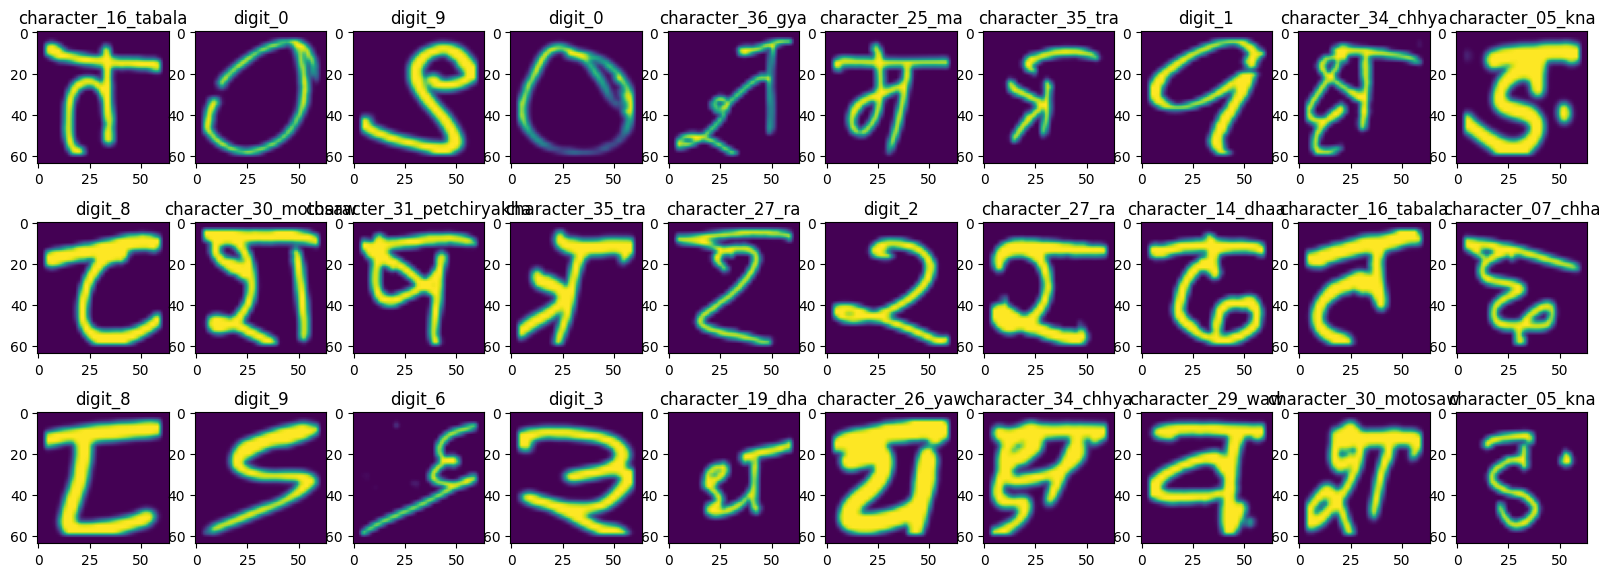

Train data size : 73600
Test data size : 18400
Train data classes : 46
Test data classes : 46
Data Loading Done !


<Figure size 640x480 with 0 Axes>

In [10]:
print('Data Loading ...')
csv_path='drive/MyDrive/GAN_data.csv'
transform = T.Compose([T.ToTensor(),T.Resize(64,antialias=False),T.Normalize((0.5,), (0.5,))])

train_set = CustomDataset(csv_path=csv_path, transform=transform,train=True)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True)

test_set = CustomDataset(csv_path=csv_path, transform=transform,train=False)
testloader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True)

view_samples(testloader, test_set.classes)
print(f'Train data size : {train_set.np_imgs.shape[0]}')
print(f'Test data size : {test_set.np_imgs.shape[0]}')
print(f'Train data classes : {train_set.classes.shape[0]}')
print(f'Test data classes : {test_set.classes.shape[0]}')
print('Data Loading Done !')


torch.Size([64, 1, 64, 64])


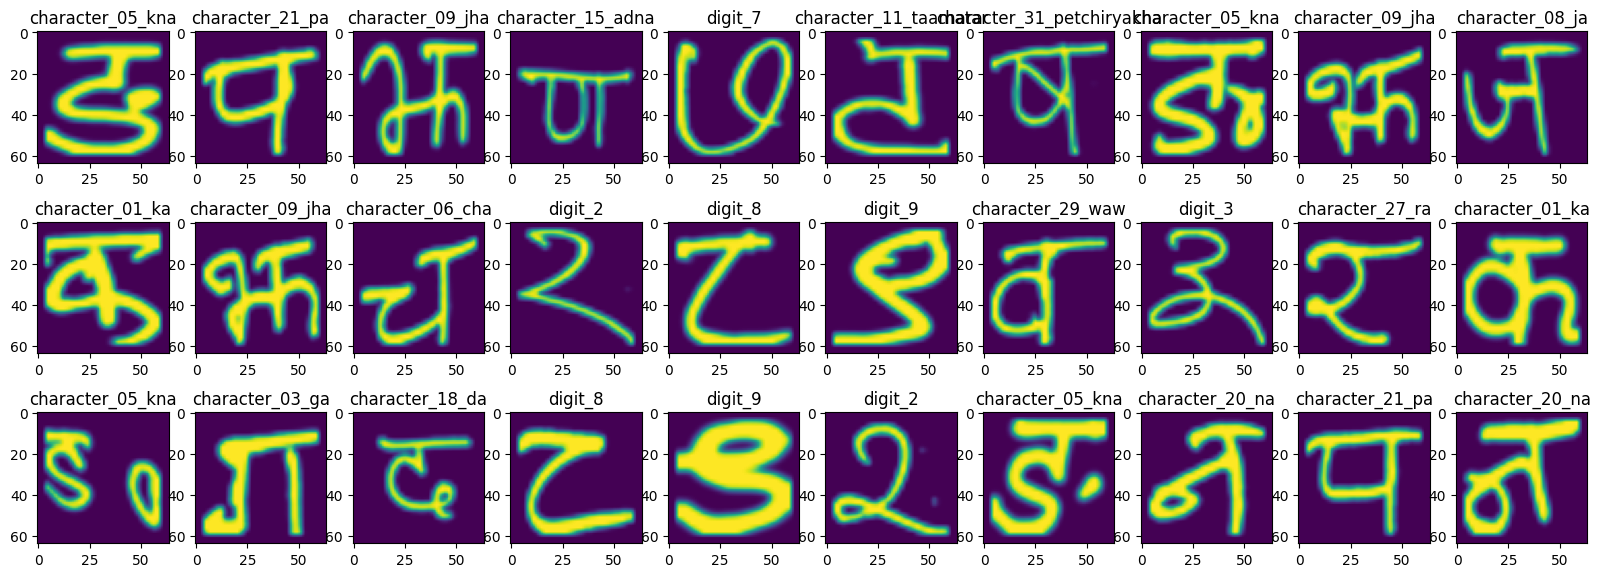

<Figure size 640x480 with 0 Axes>

In [11]:
view_samples(trainloader, train_set.classes)

In [12]:
def get_model_mobilenet_cifar10(n_class = 10):
    model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)
    model.features[0][0]=torch.nn.Conv2d(1 ,32, kernel_size=(3,3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, n_class)
    #model.classifier[2] = torch.nn.Softmax(dim=1)
    model = model.to(device)
    #print(model)
    return model

Epoch: 1 (1m 1s) 	Training Loss: 1.325, 	Test Loss: 0.250,  	Training acc: 0.67, 	Test acc: 0.93, 
Epoch: 2 (2m 5s) 	Training Loss: 0.167, 	Test Loss: 0.100,  	Training acc: 0.95, 	Test acc: 0.97, 
Epoch: 3 (3m 4s) 	Training Loss: 0.079, 	Test Loss: 0.058,  	Training acc: 0.98, 	Test acc: 0.98, 
Epoch: 4 (4m 5s) 	Training Loss: 0.048, 	Test Loss: 0.043,  	Training acc: 0.99, 	Test acc: 0.99, 
Epoch: 5 (5m 5s) 	Training Loss: 0.032, 	Test Loss: 0.038,  	Training acc: 0.99, 	Test acc: 0.99, 
Training completed in 5m 5s 	Training Loss: 0.032, 	Test Loss: 0.038,  	Training acc: 0.99, 	Test acc: 0.99, 


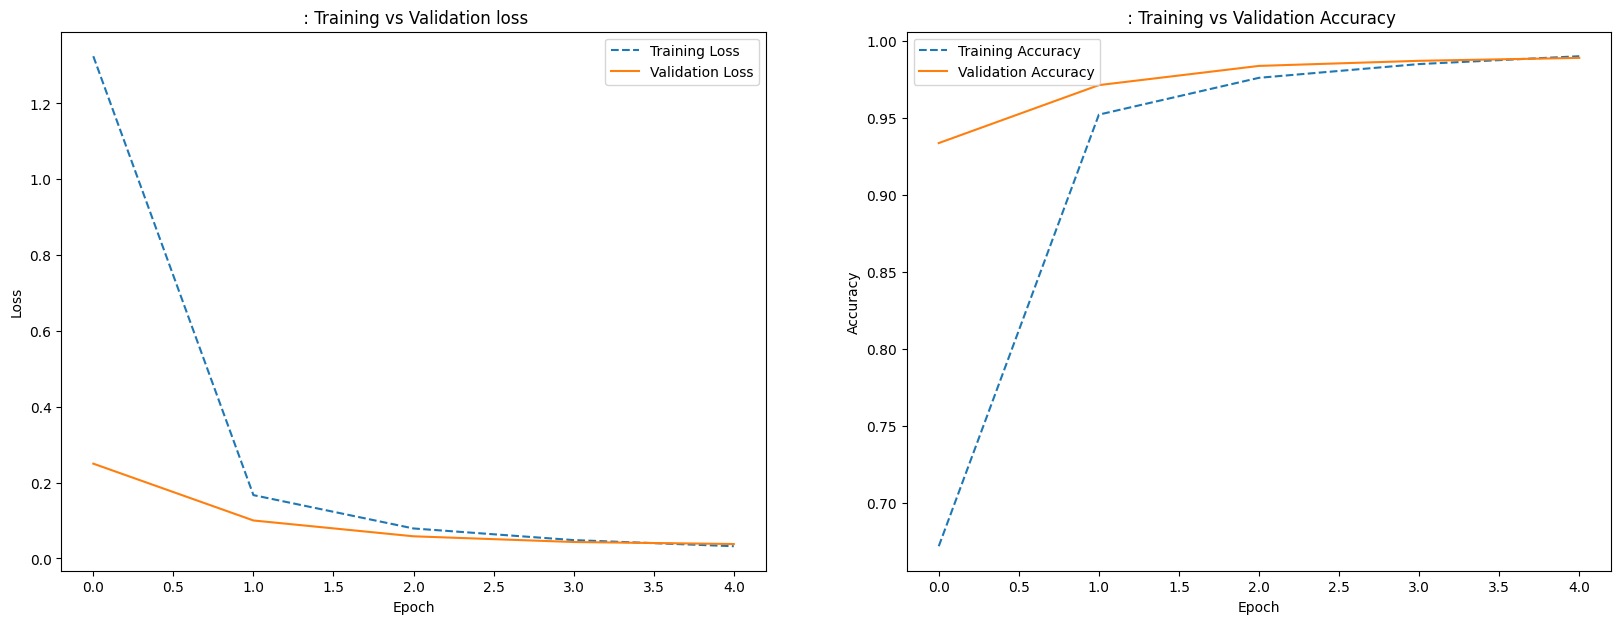

<Figure size 640x480 with 0 Axes>

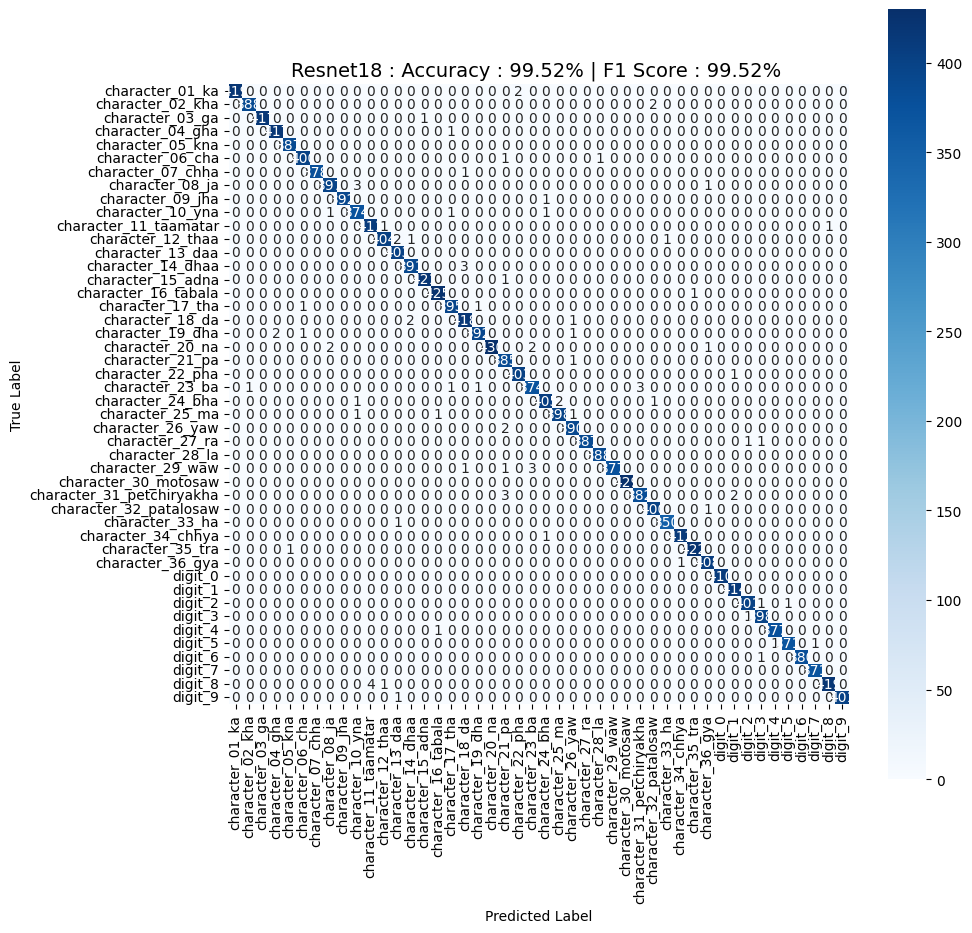

Accuracy: 99.516%
F1 Score: 99.516%

Classwise Accuracy Score: 
|   character_01_ka |   character_02_kha |   character_03_ga |   character_04_gha |   character_05_kna |   character_06_cha |   character_07_chha |   character_08_ja |   character_09_jha |   character_10_yna |   character_11_taamatar |   character_12_thaa |   character_13_daa |   character_14_dhaa |   character_15_adna |   character_16_tabala |   character_17_tha |   character_18_da |   character_19_dha |   character_20_na |   character_21_pa |   character_22_pha |   character_23_ba |   character_24_bha |   character_25_ma |   character_26_yaw |   character_27_ra |   character_28_la |   character_29_waw |   character_30_motosaw |   character_31_petchiryakha |   character_32_patalosaw |   character_33_ha |   character_34_chhya |   character_35_tra |   character_36_gya |   digit_0 |   digit_1 |   digit_2 |   digit_3 |   digit_4 |   digit_5 |   digit_6 |   digit_7 |   digit_8 |   digit_9 |
|------------------:|---------------

<Figure size 640x480 with 0 Axes>

In [13]:
model = get_model_mobilenet_cifar10(train_set.classes.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
loss_list, t, train_a, test_a = model_training(
model, criterion, optimizer, trainloader, testloader, num_epochs=5)
plot_training_graphs(loss_list)
model.eval()
with torch.no_grad():
    test_labels = []
    test_output = []
    for batch_idx, batch in enumerate(testloader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        test_labels += y.cpu()
        test_output += torch.argmax(y_hat, dim=1).cpu()

    test_labels = np.array(test_labels)
    test_output = np.array(test_output)
    metric = confusionMatrixAndAccuracyReport(
        test_labels, test_output, test_set.classes, title=f'Resnet18')

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class generator(nn.Module):
    def __init__(self,d=128):
        
        super(generator,self).__init__()
        
        self.deconv1_z = nn.ConvTranspose2d( 100 , d*2 , 4 , 1 , 0)
        self.deconv1_y = nn.ConvTranspose2d( 10, d*2 , 4 , 1, 0)
        
        self.batch_norm_1 = nn.BatchNorm2d(d*2)
        
        self.deconv2 = nn.ConvTranspose2d(d*4 , d*2, 4, 2, 1)
        self.batch_norm_2 = nn.BatchNorm2d(d*2)
        
        self.deconv3 = nn.ConvTranspose2d(d*2 , d , 4 , 2 , 1)
        self.batch_norm_3 = nn.BatchNorm2d(d)
        
        self.deconv4 = nn.ConvTranspose2d(d , 1 , 4, 2 , 1)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean , std)
            
    def forward(self , input , label):
        x = F.relu(self.batch_norm_1(self.deconv1_z(input)))
        y = F.relu(self.batch_norm_1(self.deconv1_y(label)))
        
        x = torch.cat([x,y],1)
        
        x = F.relu(self.batch_norm_2(self.deconv2(x)))
        
        x = F.relu(self.batch_norm_3(self.deconv3(x)))
        
        x = F.tanh(self.deconv4(x))
        
        return x

class discriminator(nn.Module):
    def __init__(self, d = 128):
        
        super( discriminator, self).__init__()
        print("hello")
        self.conv1_x = nn.Conv2d(1 , d//2 , 4, 2, 1)
        self.conv1_y = nn.Conv2d(10 , d//2 , 4, 2, 1)
        
        self.conv2 = nn.Conv2d( d, d*2, 4, 2, 1)
        self.batch_norm_2 = nn.BatchNorm2d(d*2)
        
        self.conv3 = nn.Conv2d( d*2, d*4, 4 , 2, 1)
        self.batch_norm_3 = nn.BatchNorm2d(d*4)
        
        self.conv4 = nn.Conv2d( d*4, 1, 4, 1, 0)
        
    def weight_init(self, mean , std):
        for m in self._modules:
            normal_init(self._modules[m], mean , std)
            
    def forward(self, input  , label):
        x = F.leaky_relu(self.conv1_x(input),0.2)
        y = F.leaky_relu(self.conv1_y(label),0.2)
        
        x = torch.cat([x,y],1)
        
        x = F.leaky_relu(self.batch_norm_2(self.conv2(x)),0.2)
        
        x = F.leaky_relu(self.batch_norm_3(self.conv3(x)),0.2)
        
        x = F.sigmoid(self.conv4(x))
        
        return x
    
    
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()       
        
        
generator = generator()
discriminator = discriminator()

generator.weight_init(mean = 0 , std = 0.02)
discriminator.weight_init(mean = 0 , std = 0.02)

generator.cuda()
discriminator.cuda()

hello


discriminator(
  (conv1_x): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_y): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [15]:
from torch.autograd import Variable


lr = 0.0002
img_size = 32
batch_size = 512
num_epochs = 40
save_dir = 'results'
G_input_dim = 100
G_output_dim = 1
D_input_dim = 1
D_output_dim = 1
label_dim = 10

def to_var(x):
    x = x.cuda()
    return Variable(x)

def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1) 

In [16]:
def plot_loss(d_losses, g_losses, num_epoch, save=True ,show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        save_fn = save_dir + 'MNIST_cDCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

def plot_result(generator, noise, label, num_epoch, save=True, show=False, fig_size=(5, 5)):
    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        ax.imshow(img.cpu().data.view(img_size, img_size).numpy(), cmap='gray', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = save_dir + 'MNIST_cDCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [17]:
opt_Gen = torch.optim.Adam(generator.parameters(),lr = lr , betas = (.5, .999))
opt_Disc = torch.optim.Adam(discriminator.parameters(),lr = lr , betas = (.5, .999))

criterion = torch.nn.BCELoss()

In [18]:
# num_test_samples = 10*10
temp_noise = torch.randn(label_dim, G_input_dim)
fixed_noise = temp_noise
fixed_c = torch.zeros(label_dim, 1)
for i in range(9):
    fixed_noise = torch.cat([fixed_noise, temp_noise], 0)
    temp = torch.ones(label_dim, 1) + i
    fixed_c = torch.cat([fixed_c, temp], 0)

fixed_noise = fixed_noise.view(-1, G_input_dim, 1, 1)
fixed_label = torch.zeros(G_input_dim, label_dim)
fixed_label.scatter_(1, fixed_c.type(torch.LongTensor), 1)
fixed_label = fixed_label.view(-1, label_dim, 1, 1)

# label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
fill = torch.zeros([label_dim, label_dim, img_size, img_size],device=device)
for i in range(label_dim):
    fill[i, i, :, :] = 1

D_avg_losses = []
G_avg_losses = []





for epoch in range(1, num_epochs +1):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    generator.train()
    if epoch == 5 or epoch == 10:
        opt_Gen.param_groups[0]['lr'] /=2
        opt_Disc.param_groups[0]['lr'] /=2
        
    
    for i, (real_images,real_labels) in enumerate(trainloader):
        minibatch = real_images.size()[0]
        real_images = Variable(real_images.cuda())
        
        #labels
        #real_labels = real_labels.cuda()
        y_real = Variable(torch.ones(minibatch).cuda())
        y_fake = Variable(torch.zeros(minibatch).cuda())
        c_fill = Variable(fill[real_labels])
        z_ = torch.randn(minibatch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())
        ## Train Discriminator             
        # first with real data
        
        D_real_decision = discriminator(real_images, c_fill).squeeze()
        D_real_loss = criterion(D_real_decision, y_real)
        
        # Then with fake data
        
        c_ = (torch.rand(minibatch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        c_fill_ = Variable(fill[c_].cuda())
        
        generator_image = generator(z_, c_onehot_) 
        D_fake_decision = discriminator(generator_image,c_fill_).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake)
        
        # Optimization
        discriminator.zero_grad()
        D_loss = D_fake_loss + D_real_loss
        D_loss.backward()
        opt_Disc.step()
        
        # Train Generator
        
        generator_image = generator(z_, c_onehot_)
        c_fill = Variable(fill[c_].cuda())
        D_fake_decision = discriminator(generator_image,c_fill).squeeze()
        G_loss = criterion(D_fake_decision, y_real)
        
        # Optimization
        generator.zero_grad()
        G_loss.backward()
        opt_Gen.step()
        
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())
        
        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
            % (epoch+1, num_epochs, i+1, len(trainloader), D_loss.item(), G_loss.item()))
        
    torch.save(generator.state_dict(), 'model_weights/generator_param.pkl')
    torch.save(discriminator.state_dict(), 'model_weights/discriminator_param.pkl')
    
    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True)

    # Show result for fixed noise
    plot_result(generator, fixed_noise, fixed_label, epoch, save=True)
    
    

RuntimeError: ignored

In [ ]:

# Make gif
loss_plots = []
gen_image_plots = []
for epoch in range(2,24):
    # plot for generating gif
    save_fn1 = 'Model resultsMNIST_cDCGAN_losses_epoch_{:d}'.format(epoch + 1) + '.png'
    loss_plots.append(imageio.imread(save_fn1))

    save_fn2 = 'Model resultsMNIST_cDCGAN_epoch_{:d}'.format(epoch + 1) + '.png'
    gen_image_plots.append(imageio.imread(save_fn2))

imageio.mimsave('MNIST_cDCGAN_losses_epochs_{:d}'.format(num_epochs) + '.gif', loss_plots, fps=5)
imageio.mimsave('MNIST_cDCGAN_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)